In [1]:
# Data Import
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)

from pyriemann.classification import MDM
from pyriemann.estimation import ERPCovariances
from tqdm import tqdm

import sys
sys.path.append('./py.BI.EEG.2015b-GIPSA/')
from braininvaders2015b.dataset import BrainInvaders2015b

from scipy.io import loadmat
import numpy as np
import mne

import joblib
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
 
dataset = BrainInvaders2015b() # datapath="T:\Kaggle\BCIBachelorThesis\Data"

In [2]:
dataset.pair_list

sorted_channels = ['FC6_1', 'Pz_2', 'T7_2', 'PO8_1', 'P8_1', 'P7_1', 'P3_2', 'P3_1', 'FC5_1', 'FC2_2', 'F8_1', 'C4_1', 'C3_1', 'T8_2', 'STI 014', 'Pz_1', 'PO9_2', 'PO9_1', 'PO7_2', 'PO10_2', 'P7_2', 'Oz_1', 'O2_1', 'O1_1', 'FP1_2', 'FC5_2', 'FC2_1', 'F7_1', 'F4_1', 'F3_1', 'CP1_1', 'AFz_2', 'AFz_1', 'T8_1', 'T7_1', 'PO8_2', 'PO10_1', 'P8_2', 'P4_2', 'P4_1', 'Oz_2', 'O2_2', 'O1_2', 'FP2_2', 'FP2_1', 'FC6_2', 'FC1_2', 'F7_2', 'F4_2', 'F3_2', 'Cz_2', 'Cz_1', 'CP6_1', 'CP5_2', 'CP5_1', 'CP2_2', 'CP2_1', 'C4_2', 'C3_2', 'FP1_1', 'FC1_1', 'F8_2', 'CP6_2', 'CP1_2', 'PO7_1']
stim_pos = np.where(np.array(sorted_channels)=="STI 014")[0][0]
stim_pos

14

In [4]:
scores = {}

largeRaws = []

for pair in dataset.pair_list[:4]: # change this to change nr of pairs
    scores[pair] = {}

    print('pair', str(pair))
    sessions = dataset._get_single_pair_data(pair=pair)
    for session_name in sessions.keys():

        scores[pair][session_name] = {}

        raw = sessions[session_name]['run_1']
        
        # filter channels right away
        pick_channels = sorted_channels[:] #+ ["STI 014"]
        raw_subject = raw.copy().pick_channels(pick_channels)
        largeRaws.append(raw_subject) # _subject

pair 1
pair 2
pair 3
pair 4


## Data Inspection

In [5]:


raw.info


<Info | 7 non-empty values
 bads: []
 ch_names: FP1_1, FP2_1, AFz_1, F7_1, F3_1, F4_1, F8_1, FC5_1, FC1_1, ...
 chs: 64 EEG, 1 STIM
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 65
 projs: []
 sfreq: 512.0 Hz
>

In [6]:
saveMemory = True
if saveMemory:
    del dataset,raw

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 1691 samples (3.303 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge:

- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 1691 samples (3.303 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 1691 samples (3.303 sec)



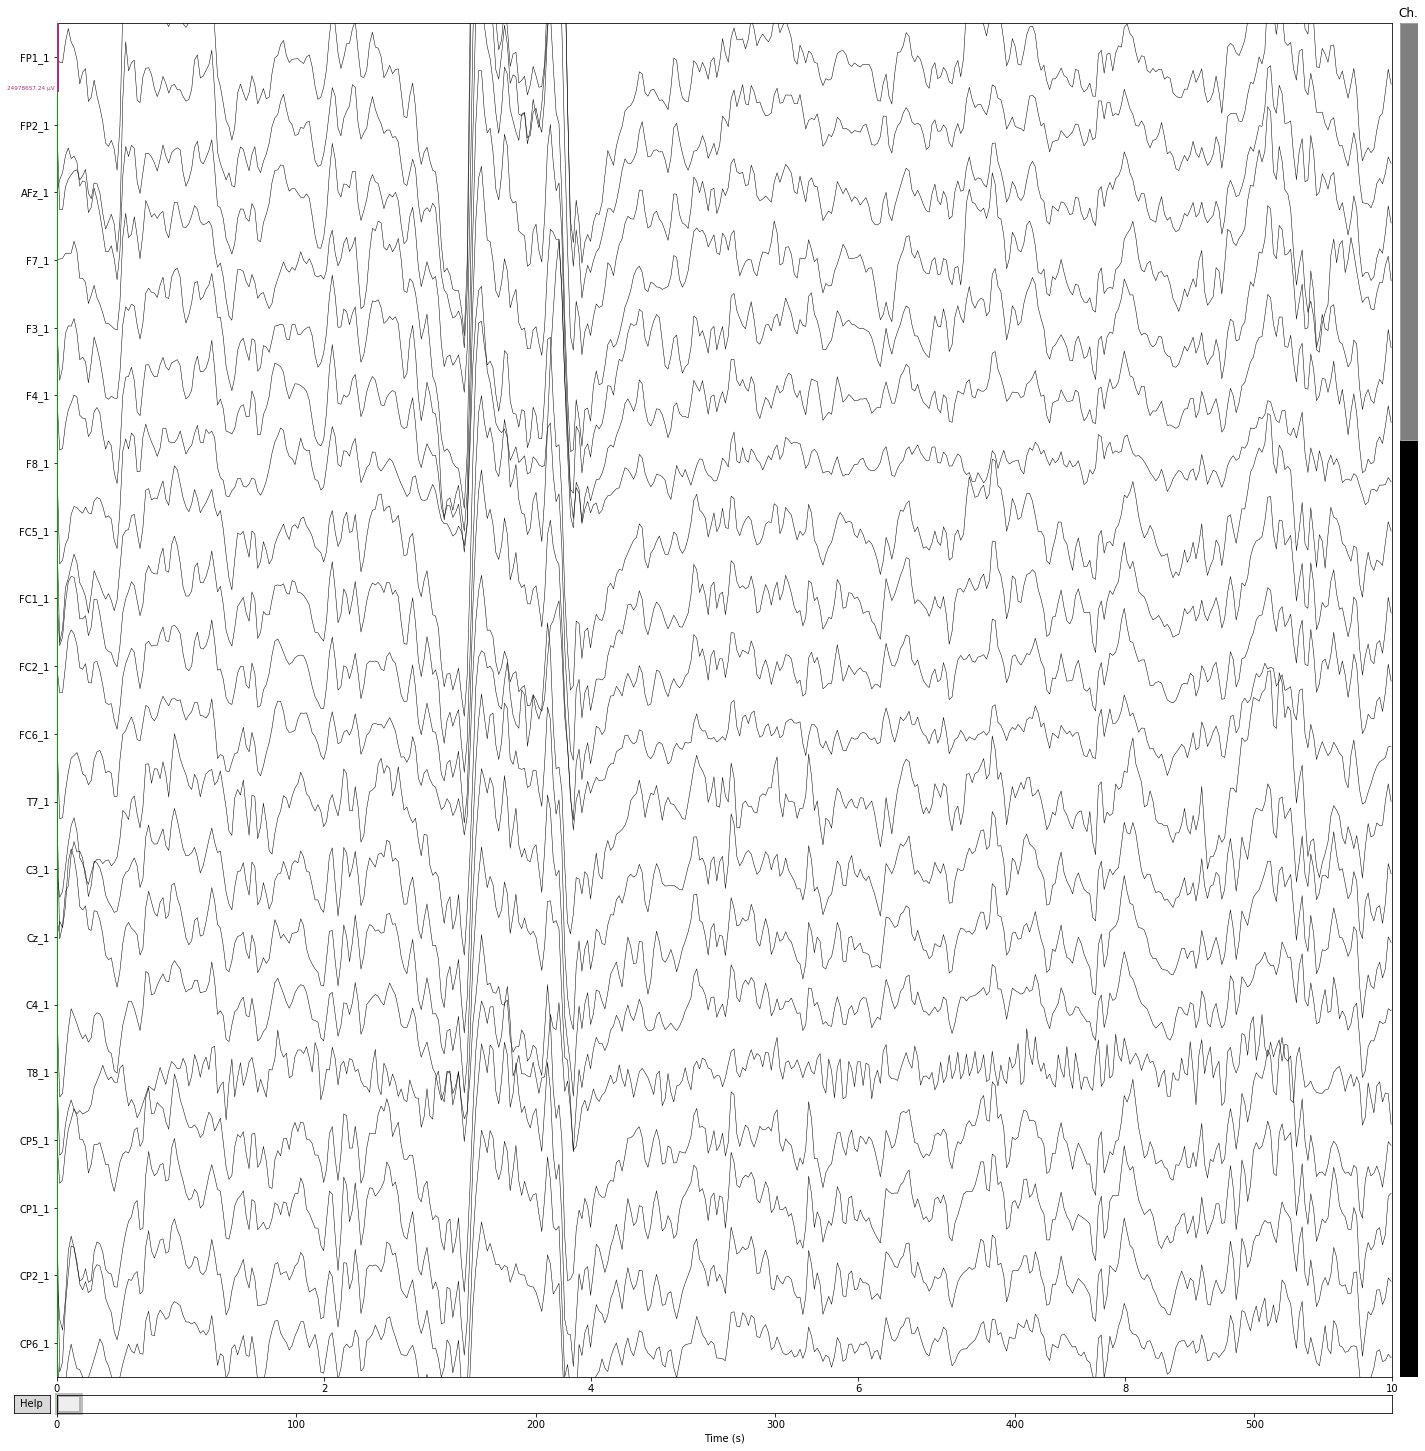

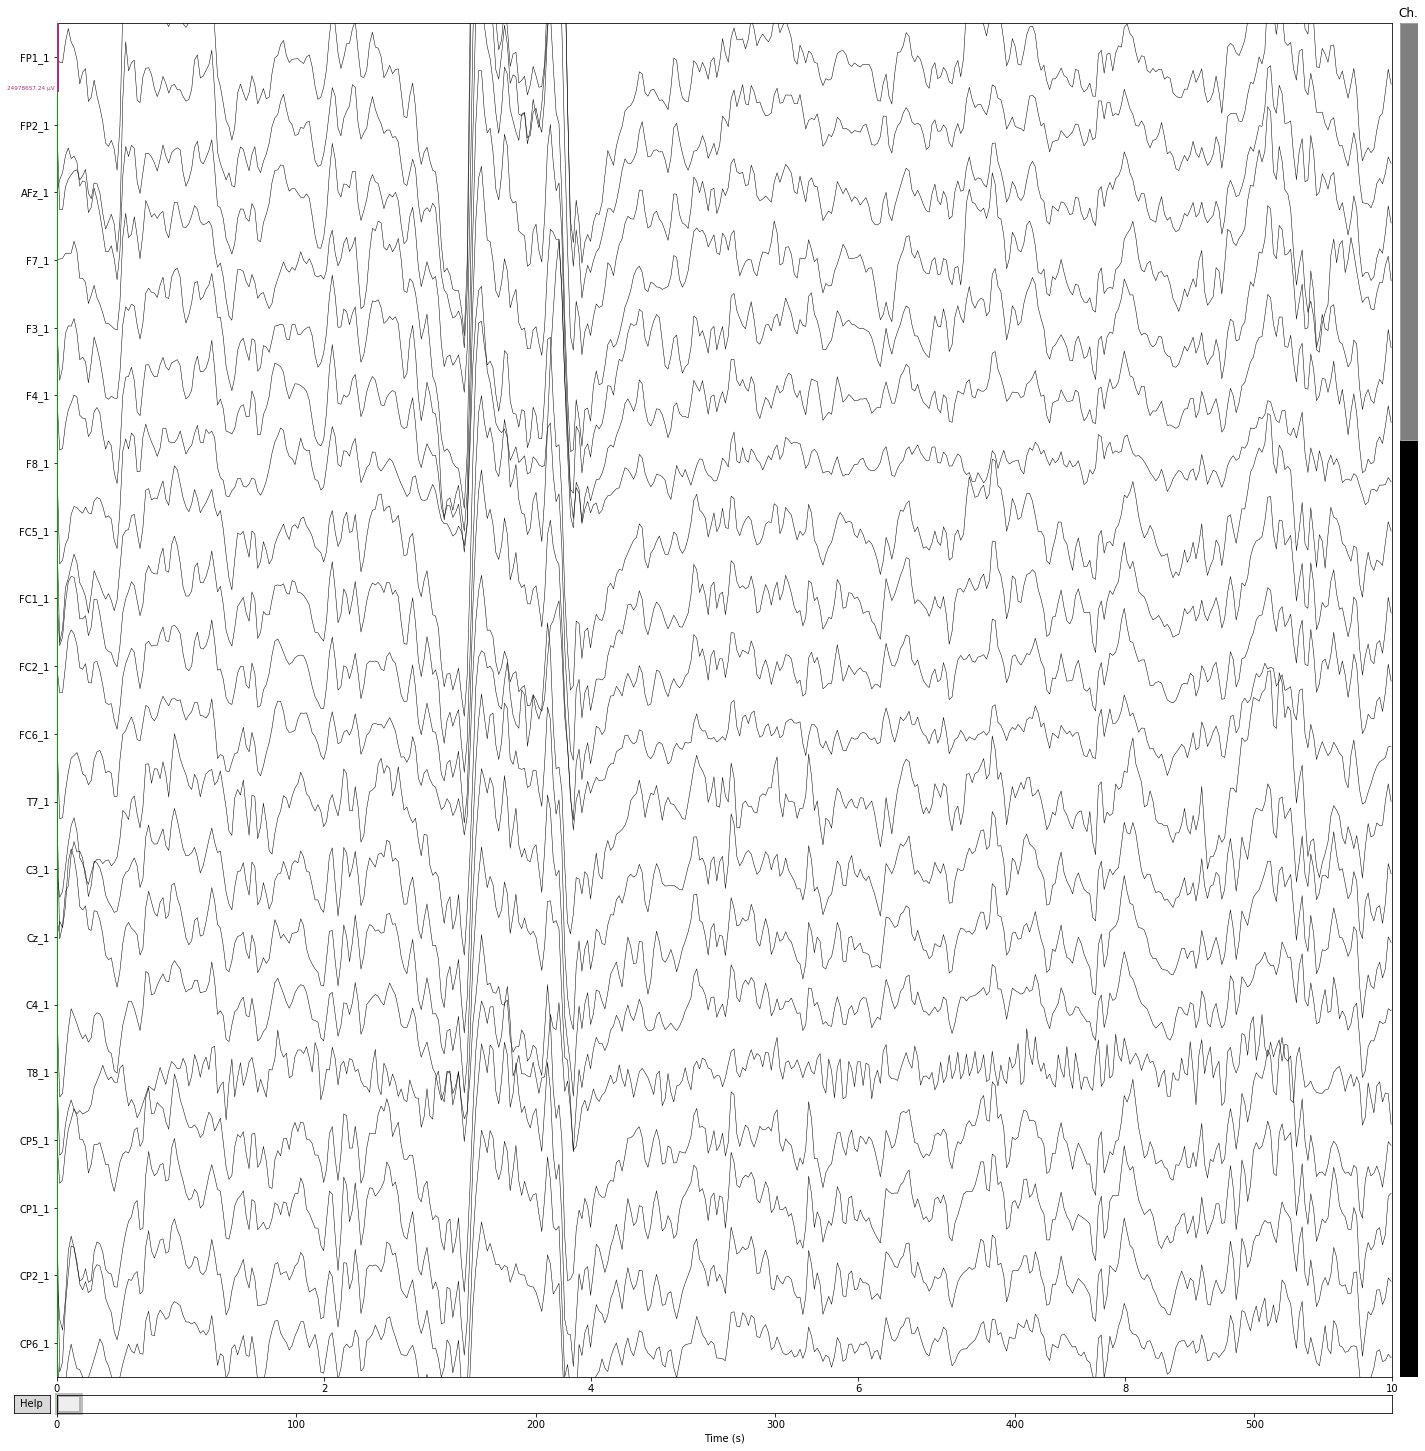

In [7]:
# After filteirng
for raw in largeRaws:
    fmin = 1
    fmax = 15
    raw.filter(fmin, fmax, verbose=True)   
#     raw.plot(scalings='auto')

largeRaws[0].plot(scalings="auto")

In [8]:
allEvents = []
for i,raw in enumerate(largeRaws):
    try:
        events = mne.find_events(raw) #  stim_channel='STI 014'
        allEvents.append(events)
    except ValueError as e:
        print(e)
        print("will skip trial no %d"%i)
# events

834 events found
Event IDs: [  1   2 100 102 104 105 106 107 108 109 110 111 160 161 163 164 165 181
 182 183 184 185]
834 events found
Event IDs: [  1   2 100 102 104 105 106 107 108 109 110 111 112 160 162 163 164 165
 180 181 183 184 185]
833 events found
Event IDs: [  1   2 100 102 104 105 106 107 108 109 110 111 112 160 161 162 163 165
 180 181 182 183 184 185]
833 events found
Event IDs: [  1   2 100 102 104 106 107 108 109 110 111 112 160 161 162 163 164 165
 180 181 182 183 184 185]
834 events found
Event IDs: [  1   2 100 102 104 105 106 107 108 109 110 111 160 161 164 165 180 182
 183 184 185]
833 events found
Event IDs: [  1   2 100 102 104 105 106 107 108 109 110 111 160 161 162 163 164 165
 180 181 183 184 185]
833 events found
Event IDs: [  1   2 100 102 104 105 107 108 109 110 111 160 162 163 164 180 181 183
 184]
833 events found
Event IDs: [  1   2 100 102 104 105 106 107 108 109 110 111 112 161 162 163 164 165
 180 181 182 183 184 185]
833 events found
Event IDs: [  1

In [9]:
len(largeRaws),len(allEvents)

(16, 16)

In [10]:
allEpochs = []
from tqdm import tqdm
for raw,events in tqdm(zip(largeRaws,allEvents)):
    event_id = {'NonTarget': 1, 'Target': 2}
    tmin = 0  # start of each epoch (200ms before the trigger)
    tmax = 0.8  # end of each epoch (500ms after the trigger)
#     print(event_id)
    baseline = None  # means from the first instant to t = 0
    epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                        baseline=baseline, preload=False)
#     print(epochs)
    allEpochs.append(epochs)

del largeRaws

0it [00:00, ?it/s]

660 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
660 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
660 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
660 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
660 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
660 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
660 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
660 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
660 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
660 matching events found
No baseline

14it [00:00, 132.08it/s]

660 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
660 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


16it [00:00, 132.23it/s]


In [11]:
len(allEvents),len(allEpochs)

(16, 16)

## Combining all data



In [105]:
allX = []
ally = []

for epochs in allEpochs:
    X = epochs.get_data()
    # need to drop the stimulus channel
    try:
        X = np.delete(X,stim_pos,axis=1)
    except IndexError:
        pass
        # not there anyways
    y = epochs.events[:,-1]
#     X1 = X[:,:32,:]
#     X2 = X[:,32:,:]
#     X = np.concatenate([X1,X2], axis=0)
    y = y - 1  
#     doubley = []
#     for j in y:
#         doubley.append(j)
#         doubley.append(j)
    allX.append(X)
    ally.append(y)
    
# del allEpochs,allEvents

allX = np.concatenate(allX, axis=0)
ally = np.concatenate(ally, axis=0)
print(np.shape((allX)),np.shape(ally))



Loading data for 660 events and 411 original time points ...
Loading data for 660 events and 411 original time points ...
Loading data for 660 events and 411 original time points ...
Loading data for 660 events and 411 original time points ...
Loading data for 660 events and 411 original time points ...
Loading data for 660 events and 411 original time points ...
Loading data for 660 events and 411 original time points ...
Loading data for 660 events and 411 original time points ...
Loading data for 660 events and 411 original time points ...
Loading data for 660 events and 411 original time points ...
Loading data for 660 events and 411 original time points ...
Loading data for 660 events and 411 original time points ...
Loading data for 660 events and 411 original time points ...
Loading data for 630 events and 411 original time points ...
Loading data for 660 events and 411 original time points ...
Loading data for 660 events and 411 original time points ...
(10530, 64, 411) (10530,

# Classification

In [106]:
# train test split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

x_train, x_test, y_train, y_test = train_test_split(allX,ally, test_size=0.33, random_state=42,shuffle=True) # Xxdawn, ally


# do we have an imbalance?
distr = np.unique(y_train,return_counts=True)
print(distr)
ratio = distr[1][0]/distr[1][1]
print(ratio)
# yes! use class weights to fight this effect
targetsOnly = x_train[y_train==1.]
targetsOnly = np.repeat(targetsOnly,int(ratio)-1,axis=0) # upsample undersampled target array, minus one bc we already have that one set
nradds = len(targetsOnly)
print("upsampled %d trials"%nradds)
x_train = np.concatenate([x_train,targetsOnly])
y_train = np.concatenate([y_train,np.ones(nradds)],axis=0)


class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train), y_train,classes=[0, 1])
print("class weights used: ",class_weights)
# new class weights
class_weights = [.25,.75] # second class more important

# del allX,ally # memory

x_train.shape,y_train.shape

(array([0, 1], dtype=int64), array([5750, 1305], dtype=int64))
4.406130268199234
upsampled 3915 trials
class weights used:  [0.95391304 1.05076628]


((10970, 64, 411), (10970,))

Report for winning model:
              precision    recall  f1-score   support

  Non-Target       0.96      0.85      0.90      2860
      Target       0.54      0.83      0.65       615

    accuracy                           0.84      3475
   macro avg       0.75      0.84      0.77      3475
weighted avg       0.88      0.84      0.85      3475



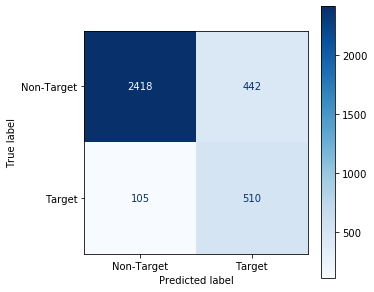

In [107]:
from pyriemann.estimation import ERPCovariances
from pyriemann.spatialfilters import Xdawn
from pyriemann.classification import MDM
from pyriemann.tangentspace import TangentSpace

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC

aweight = 0.5
class_weights = { 0:aweight, 1:1-aweight } 


xdawn = Xdawn()
x_train_XDAWN = xdawn.fit_transform(x_train,y_train)
x_test_XDAWN = xdawn.transform(x_test)

mdm = MDM(n_jobs=-1, metric = "logdet")
# svc = SVC(class_weight=class_weights)
covest = ERPCovariances(estimator="lwf")
ts = TangentSpace()
clf = make_pipeline(covest,mdm)

clf.fit(x_train_XDAWN,y_train)

pred = clf.predict(x_test_XDAWN)

class_names = ["Non-Target","Target"]
cr = classification_report(y_test,pred,target_names=class_names) # 
print("Report for winning model:")
print(cr)

plt.rcParams["figure.figsize"] = (5,5)
plot_confusion_matrix(clf,x_test_XDAWN,y_test,cmap=plt.cm.Blues,display_labels=class_names)#normalize="false"
plt.show()

In [60]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [89]:
# HIGH error rate with target class!

# 0.15

scrs = []
for i in tqdm(np.linspace(0.05,0.95,19)):
    class_weights = { 0:i, 1:1-i } 

    # xdawn = Xdawn()
    # x_train_XDAWN = xdawn.fit_transform(x_train,y_train)
    # x_test_XDAWN = xdawn.transform(x_test)

    # mdm = MDM(n_jobs=-1, metric = "logdet")
    svc = SVC(class_weight=class_weights)
    covest = ERPCovariances(estimator="lwf")
    ts = TangentSpace()
    clf = make_pipeline(covest,ts,svc)
    clf.fit(x_train_XDAWN,y_train)

    pred = clf.predict(x_test_XDAWN)

    class_names = ["Non-Target","Target"]
    cr = classification_report(y_test,pred,target_names=class_names,output_dict=True) # 
    scr = cr["Target"]["f1-score"]
    
    print("score of 0:%.2f is : %f"%(i,scr))
    scrs.append(scr)

  0%|                                                                                                                   | 0/5 [00:27<?, ?it/s]


KeyboardInterrupt: 

In [86]:
#LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.metrics import FalseNegatives,Precision

model = Sequential()
model.add(LSTM(units = 50, return_sequences = False, input_shape = (x_train_XDAWN.shape[1], x_train_XDAWN.shape[2])))
model.add(Dropout(0.2))

# model.add(LSTM(units = 15, return_sequences = True))
# model.add(Dropout(0.2))



model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',FalseNegatives(),Precision()])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 50)                92400     
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 92,451
Trainable params: 92,451
Non-trainable params: 0
_________________________________________________________________
None


In [87]:
redlr = ReduceLROnPlateau(monitor='accuracy',patience=10)
es = EarlyStopping(monitor='accuracy', min_delta=0.0001,patience=50)


hist = model.fit(x_train_XDAWN,y_train,batch_size=128, validation_data=(x_test_XDAWN,y_test),epochs=2000,callbacks=[es,redlr], class_weight= class_weights)
 #0,8504

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 10970 samples, validate on 3475 samples
Epoch 1/2000
10970/10970 [==============================] - 3s 233us/sample - loss: 0.2268 - accuracy: 0.6352 - false_negatives_4: 3736.0000 - precision_4: 0.8480 - val_loss: 0.1606 - val_accuracy: 0.8622 - val_false_negatives_4: 411.0000 - val_precision_4: 0.7500
Epoch 2/2000
10970/10970 [==============================] - 1s 70us/sample - loss: 0.1638 - accuracy: 0.7580 - false_negatives_4: 2475.0000 - precision_4: 0.9385 - val_loss: 0.1494 - val_accuracy: 0.8748 - val_false_negatives_4: 324.0000 - val_precision_4: 0.7239
Epoch 3/2000
10970/10970 [==============================] - 1s 70us/sample - loss: 0.1288 - accuracy: 0.8278 - false_negatives_4: 1718.0000 - precision_4: 0.9534 - val_loss: 0.1402 - val_accuracy: 0.8780 - val_false_negatives_4: 301.0000 - val_precision_4: 0.7185
Epoch 4/2000
10970/10970 [==============================] - 1s 73us/sample - loss: 0.1078 - accuracy: 0.8641

10970/10970 [==============================] - 1s 70us/sample - loss: 0.0122 - accuracy: 0.9923 - false_negatives_4: 63.0000 - precision_4: 0.9958 - val_loss: 0.2064 - val_accuracy: 0.8734 - val_false_negatives_4: 297.0000 - val_precision_4: 0.6898
Epoch 32/2000
10970/10970 [==============================] - 1s 73us/sample - loss: 0.0140 - accuracy: 0.9893 - false_negatives_4: 93.0000 - precision_4: 0.9953 - val_loss: 0.2042 - val_accuracy: 0.8682 - val_false_negatives_4: 294.0000 - val_precision_4: 0.6619
Epoch 33/2000
10970/10970 [==============================] - 1s 74us/sample - loss: 0.0129 - accuracy: 0.9896 - false_negatives_4: 89.0000 - precision_4: 0.9952 - val_loss: 0.2158 - val_accuracy: 0.8748 - val_false_negatives_4: 279.0000 - val_precision_4: 0.6829
Epoch 34/2000
10970/10970 [==============================] - 1s 71us/sample - loss: 0.0148 - accuracy: 0.9879 - false_negatives_4: 104.0000 - precision_4: 0.9944 - val_loss: 0.2086 - val_accuracy: 0.8742 - val_false_negatives

10970/10970 [==============================] - 1s 70us/sample - loss: 0.0022 - accuracy: 0.9999 - false_negatives_4: 1.0000 - precision_4: 1.0000 - val_loss: 0.2359 - val_accuracy: 0.8751 - val_false_negatives_4: 283.0000 - val_precision_4: 0.6874
Epoch 63/2000
10970/10970 [==============================] - 1s 68us/sample - loss: 0.0021 - accuracy: 0.9997 - false_negatives_4: 2.0000 - precision_4: 0.9998 - val_loss: 0.2366 - val_accuracy: 0.8740 - val_false_negatives_4: 286.0000 - val_precision_4: 0.6840
Epoch 64/2000
10970/10970 [==============================] - 1s 70us/sample - loss: 0.0021 - accuracy: 0.9999 - false_negatives_4: 1.0000 - precision_4: 1.0000 - val_loss: 0.2359 - val_accuracy: 0.8731 - val_false_negatives_4: 290.0000 - val_precision_4: 0.6828
Epoch 65/2000
10970/10970 [==============================] - 1s 69us/sample - loss: 0.0022 - accuracy: 0.9996 - false_negatives_4: 4.0000 - precision_4: 1.0000 - val_loss: 0.2370 - val_accuracy: 0.8731 - val_false_negatives_4: 2

10970/10970 [==============================] - 1s 70us/sample - loss: 0.0017 - accuracy: 0.9998 - false_negatives_4: 2.0000 - precision_4: 1.0000 - val_loss: 0.2394 - val_accuracy: 0.8740 - val_false_negatives_4: 285.0000 - val_precision_4: 0.6832
Epoch 94/2000
10970/10970 [==============================] - 1s 68us/sample - loss: 0.0018 - accuracy: 0.9996 - false_negatives_4: 3.0000 - precision_4: 0.9998 - val_loss: 0.2394 - val_accuracy: 0.8740 - val_false_negatives_4: 285.0000 - val_precision_4: 0.6832
Epoch 95/2000
10970/10970 [==============================] - 1s 68us/sample - loss: 0.0017 - accuracy: 0.9996 - false_negatives_4: 4.0000 - precision_4: 1.0000 - val_loss: 0.2394 - val_accuracy: 0.8740 - val_false_negatives_4: 285.0000 - val_precision_4: 0.6832
Epoch 96/2000
10970/10970 [==============================] - 1s 70us/sample - loss: 0.0016 - accuracy: 0.9999 - false_negatives_4: 1.0000 - precision_4: 1.0000 - val_loss: 0.2394 - val_accuracy: 0.8740 - val_false_negatives_4: 2

Report for winning model:
              precision    recall  f1-score   support

  Non-Target       0.90      0.95      0.93      2860
      Target       0.68      0.54      0.60       615

    accuracy                           0.87      3475
   macro avg       0.79      0.74      0.76      3475
weighted avg       0.87      0.87      0.87      3475



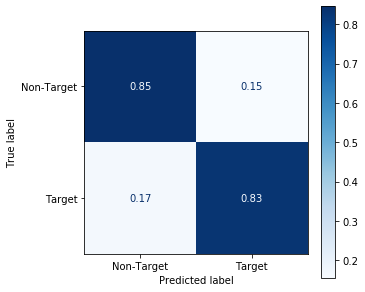

{0: 0.75, 1: 0.25}


In [88]:
pred = model.predict_classes(x_test_XDAWN)
np.unique(pred,return_counts=True)

class_names = ["Non-Target","Target"]
cr = classification_report(y_test,pred,target_names=class_names)
print("Report for winning model:")
print(cr)

plt.rcParams["figure.figsize"] = (5,5)
plot_confusion_matrix(clf,x_test_XDAWN,y_test,cmap=plt.cm.Blues,display_labels=class_names,normalize="true")
plt.show()
print(class_weights)

## Hyperparameter Tuning of SVC final

In [108]:
# HIGH error rate with target class!

# 0.15

scrs = []
combs = []
for kernel in tqdm(['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']):
    for dec_fct in ['ovo', 'ovr']:
        try:
            i = 0.75
            class_weights = { 0:i, 1:1-i } 

            # xdawn = Xdawn()
            # x_train_XDAWN = xdawn.fit_transform(x_train,y_train)
            # x_test_XDAWN = xdawn.transform(x_test)

            # mdm = MDM(n_jobs=-1, metric = "logdet")
            svc = SVC(class_weight=class_weights,kernel=kernel,decision_function_shape=dec_fct)
            covest = ERPCovariances(estimator="lwf")
            ts = TangentSpace()
            clf = make_pipeline(covest,ts,svc)
            clf.fit(x_train_XDAWN,y_train)

            pred = clf.predict(x_test_XDAWN)

            class_names = ["Non-Target","Target"]
            cr = classification_report(y_test,pred,target_names=class_names,output_dict=True) # 
            scr = cr["Target"]["f1-score"]
        except:
            scr = 0.
            # not possible

        combs.append("-".join([kernel,dec_fct]))
        scrs.append(scr)
        print(combs[-1],scr)

  0%|                                                                                                                   | 0/5 [00:00<?, ?it/s]

linear-ovo 0.7364016736401673


 20%|█████████████████████▍                                                                                     | 1/5 [01:16<05:06, 76.55s/it]

linear-ovr 0.7364016736401673
poly-ovo 0.6364572605561276


 40%|██████████████████████████████████████████▊                                                                | 2/5 [02:42<03:58, 79.48s/it]

poly-ovr 0.6364572605561276
rbf-ovo 0.7652173913043477


 60%|████████████████████████████████████████████████████████████████▏                                          | 3/5 [03:53<02:33, 76.81s/it]

rbf-ovr 0.7652173913043477
sigmoid-ovo 0.7326565143824028


 80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 4/5 [04:59<01:13, 73.68s/it]

sigmoid-ovr 0.7326565143824028
precomputed-ovo 0.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:28<00:00, 65.71s/it]

precomputed-ovr 0.0


              precision    recall  f1-score   support

  Non-Target       0.94      0.97      0.95      2860
      Target       0.82      0.72      0.77       615

    accuracy                           0.92      3475
   macro avg       0.88      0.84      0.86      3475
weighted avg       0.92      0.92      0.92      3475



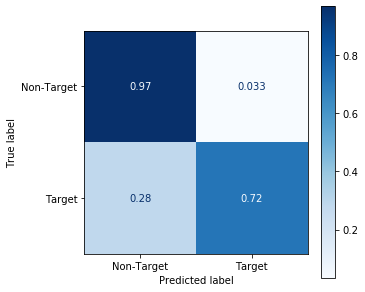

{0: 0.75, 1: 0.25}


In [93]:
# final multi-class model
from pyriemann.estimation import ERPCovariances
from pyriemann.spatialfilters import Xdawn
from pyriemann.classification import MDM
from pyriemann.tangentspace import TangentSpace

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC

# define class weights
i = 0.75
class_weights = { 0:i, 1:1-i } 

# spatial filtering with xdawn
xdawn = Xdawn()
x_train_XDAWN = xdawn.fit_transform(x_train,y_train)
x_test_XDAWN = xdawn.transform(x_test)

# define the SVC classifier, ERP Covariance Estimation and TangentSpace to transform the data to a 2D form 
svc = SVC(class_weight=class_weights,kernel="rbf",decision_function_shape="ovo")
covest = ERPCovariances(estimator="lwf")
ts = TangentSpace()
clf = make_pipeline(covest,ts,svc)
clf.fit(x_train_XDAWN,y_train)

# Evaluate the prediction
pred = clf.predict(x_test_XDAWN)

class_names = ["Non-Target","Target"]
cr = classification_report(y_test,pred,target_names=class_names) # 
print(cr)
plt.rcParams["figure.figsize"] = (5,5)
plot_confusion_matrix(clf,x_test_XDAWN,y_test,cmap=plt.cm.Blues,display_labels=class_names,normalize="true")
plt.show()